![The player in blue would be whistled for 2-minute minor here.](images/header.png)

On November 21, [*The Athletic*](https://www.nytimes.com/athletic/) lead their daily NHL newsletter with the headline, "[What's Behind The NHL's Injury Explosion This Season?](https://www.nytimes.com/athletic/6826430/2025/11/21/nhl-injuries-man-games-lost-2025-26-season/)" The article begins:

> It’s been an exciting season in the NHL, for sure, with historic starts from youngsters such as Matthew Schaefer and absolute chaos in the standings. But it also feels like any time you check the newswire, another NHL star is hurt.


In [a subsequent report](https://www.nytimes.com/athletic/6879422/2025/12/11/nhl-injuries-teams-adam-fox-jack-hughes/) on December 11, *The Athletic* asserted again that "NHL injuries are on the rise." Several other articles have also referenced an increase in injuries during the first half of the season.

Both articles linked above float the idea that a compressed 2025/26 schedule, designed to accommodate the Winter Olympics, may be to blame. It's an interesting theory to test, but it also glosses over the question of whether injuries really are happening more frequently, or if we've simply observed random noise. *The Athletic* does acknowledge, "It’s plausible that, sometimes, in this random and physically demanding sport, a lot of players will simply get hurt early in a season." I agree this is plausible, maybe even likely. Fortunately, this hypothesis is readily testible using Bayesian statistics.

In the post below, I'll construct a Bayesian model to estimate historic and current injury rates in the NHL and demonstrate that the injury rate may not be quite as high as it seems. I'll also talk a little bit about why events might *seem* to be increasing in frequency, when in fact they aren't.

In [658]:
#| echo: false
#| output: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from plotly.subplots import make_subplots 
import plotly.express as px
from collections import Counter

az.style.use("arviz-white")
random_seed = 42

## Preparing The Data ##

Before modeling injury rates, I made a handful of preprocessing choices to ensure the data were internally consistent and comparable across seasons:

**Data source and structure**  


The dataset comes from the [NHL Injury Viz Man Games Lost plots](https://nhlinjuryviz.blogspot.com/2025/10/202526-NHL-man-games-lost-plots.html) (many thanks to the site's admin, L3WH, for their assistance locating and parsing the correct tables). These plots record each game missed by a given player, along with the season, team, position, and injury type. The `GameAdj` column is a cumulative game count, beginning with Game 1 of the 2000/01 season. Using this script, I converted them from a log of games missed to a list of unique injuries reported, along with the game for which they were first reported. The converted table looks like this:

In [659]:
#| echo: false

data = pd.read_csv('full_data.csv')
data.head(10)

,Player,GameAdj,Game,Injury Type,Position,Season,Team
0,"Antropov, Nik",1,1,Knee,F,2000/01,Toronto
1,"Bergevin, Marc",1,1,Thumb,D,2000/01,St. Louis
2,"Brown, Doug",1,1,Knee,F,2000/01,Detroit
3,"Burt, Adam",1,1,Cheek,D,2000/01,Atlanta
4,"Cairns, Eric",1,1,Thumb,D,2000/01,NY Islanders
5,"Chebaturkin, Vladimir",1,1,Groin,D,2000/01,St. Louis
6,"Cullimore, Jassen",1,1,Shoulder,D,2000/01,Tampa Bay
7,"Domenichelli, Hnat",1,1,Ankle,F,2000/01,Atlanta
8,"Dykhuis, Karl",1,1,Abdominal,D,2000/01,Montreal
9,"Ference, Brad",1,1,Jaw,D,2000/01,Florida


**Aggregating Injuries By Games**  


To estimate the injury rate, we'll aggregate injury counts by game and pool injuries across all the teams in the league for a given game. For example, for Game 5, the Count value is the sum of injuries reported by each team when they played their 5th game of the season.

This approach does have some drawbacks; mainly that different amounts of time pass between games for different teams at any given point in the season. Players are exposed to injury risk between games, during practice, or even at a [team dinner](https://bleacherreport.com/articles/25294520-what-jack-hughes-injury-devils-star-reportedly-cut-hand-fluke-accident). The injuries reported in the data occurred sometime between the start of the previous game and the start of the game indicated, but we can't be certain exactly when. That said, the per-game structure is very close to a constant time interval, and should be suitable for our purposes. Here's the aggregated table:

In [713]:
#| echo: false

data = pd.read_csv('full_data.csv')
injuries = data[['Season','Game','GameAdj','Player']]
injuries = injuries.groupby(['Season','Game','GameAdj'], as_index=False).count()
injuries.rename(columns={'Player':'Count'}, inplace=True)
injuries

,Season,Game,GameAdj,Count
0,2000/01,1,1,42
1,2000/01,2,2,11
2,2000/01,3,3,10
3,2000/01,4,4,10
4,2000/01,5,5,8
...,...,...,...,...
1924,2025/26,28,1925,18
1925,2025/26,29,1926,8
1926,2025/26,30,1927,7
1927,2025/26,31,1928,7


**Handling missing zero-injury games**  


The dataset only records games in which at least one injury was reported, which means we don't observe games in which zero new injuries were reported. A completeness check confirms that all game numbers in the observed range are present, despite the fact that there are no zeros in the data. Because injuries are pooled across all teams, with a league-wide per-game rate $\approx10$, the Poisson probability of a zero-injury day is $e^{-10} = .00005$ (i.e., very unlikely).

In [661]:
zeros = int(injuries[(injuries['Count'] == 0)]['Count'].count())

print(f'Zero count: {zeros}')

Zero count: 0


In [662]:
full_range = set(range(1, 1930))
observed = set(injuries['GameAdj'])
absent = sorted(full_range - observed)

print(f'Game numbers absent: {len(absent)}')

Game numbers absent: 0


**Excluding Game 1s**


Every season, teams report a large number of injuries for Game 1. These are injuries that occurred in the offseason, the pre-season, or carryover injuries from the previous season. The original data set counts games missed, which means the player was injured sometime prior to the game indicated. We're only interested in injuries that occur during the season, though, so I removed all Game 1 values to avoid inflating each season's count.

In [714]:
#| echo: false

injuries.query('Game == 1').head()

,Season,Game,GameAdj,Count
0,2000/01,1,1,42
82,2001/02,1,83,41
164,2002/03,1,165,43
246,2003/04,1,247,54
328,2005/06,1,329,47


In [715]:
#| echo: false

injuries = injuries[(injuries['Game'] > 1)]

**Excluding COVID-affected seasons**  


The 2019/20, 2020/21, and 2021/22 seasons were affected by the COVID-19 pandemic. Both 2019/20 and 2020/21 were shortened by the pandemic, and 2021/22 featured abnormally high injury counts due to COVID outbreaks. While I think there's an argument for leaving these seasons in the data, I ultimately decided that these seasons were played under a different "injury regime" than the others and removed them. Our goal is to compare 2025/26 to a typical season, but these seasons don't fit that description.

In [716]:
#| echo: false

covid = ['2019/20','2020/21', '2021/22']
injuries[injuries['Season'].isin(covid)][['Season', 'Count']].groupby('Season').sum()

,Count
Season,
2019/20,704
2020/21,775
2021/22,1454


In [ ]:
#| echo: false

injuries = injuries[~injuries['Season'].isin(covid)]

**Aligning seasons for comparison**


The data were collected on December 12th, 2025, with the 2025/26 season still in progress. A quick check against the NHL schedule (obtained from Hockey Reference) shows that every team had played at least 29 games by that date.

In [668]:
sched_25 = pd.read_csv('2025_schedule.csv')

visitor = sched_25['Visitor'].value_counts().to_dict()
home = sched_25['Home'].value_counts().to_dict()
total_played = Counter(visitor) + Counter(home)
games_so_far = min(total_played.values())

print(f'Minimum games played by all teams: {games_so_far}')

Minimum games played by all teams: 29


To see how this year's first 29 games compares to the first 29 games of each previous season, we'll truncate all the seasons to that number. Here's how they compare:

In [669]:
#| echo: false

injuries_29 = injuries.query('Game < 29')
injuries_29[['Season','Count']].groupby('Season').sum()

,Count
Season,
2000/01,333
2001/02,242
2002/03,279
2003/04,284
2005/06,316
2006/07,243
2007/08,235
2008/09,289
2009/10,318


We can see that this year's 29-game total was higher than the previous eight years, but still lower than some seasons. However, our goal is to understand if the entire season's injury rate is higher, not just the first 29 games. Fortunately we can leverage the full-season data from the past to estimate the injury rate for this season, even with incomplete data.

## Model Construction ##

Going back to the full-season data (except for 2025 which is still through 29 games), let's look at the average number of injuries reported for each game:

In [670]:
#| label: per-game-rates
#| echo: false

injuries[['Season', 'Count']].groupby(['Season']).mean().round(2)

,Count
Season,
2000/01,11.73
2001/02,10.22
2002/03,11.79
2003/04,11.09
2005/06,10.84
2006/07,10.01
2007/08,9.99
2008/09,10.46
2009/10,10.93


The rate fluctuates year to year, as low as 9.7 and as high as 11.8. 2025's early-season injury rate is 10.03, which seems to be right in line with previous years. However, we can't really say that with certainty, because it's calculated from a much smaller sample size. We want to estimate the underlying injury rate for the entire season, not just the first 29 games. In order to do that, we'll construct a hierarchical model, using the following assumptions:

* The number of injuries reported for each game as a Poisson random variable with mean $\lambda$.
* Each season's rate, $\lambda_{\text{season}}$, is itself a random variable that varies heterogeneously over time due to changes in roster composition, scheduling, and other random factors.
* The distribution of $\lambda_{\text{season}}$ is characterized by a Gamma distribution with parameters $\alpha$ and $\beta$

We'll jointly estimate each season’s injury rate as well as the parameters of the Gamma distribution governing season-to-season variation. We then use this historical Gamma distribution as a prior when estimating the possible values of $\lambda_{2026/26}$, updating it with the observed data from the first 29 games.

The Gamma distribution is parameterized in terms of its mean $m$ and concentration $k$, where $m$ represents the average injury rate across seasons and $k$ controls how tightly individual seasons cluster around that mean. Weakly informative priors are placed on both parameters, allowing a wide range of plausible season-to-season variation while ensuring stable inference. These parameters are then converted into the corresponding $\alpha$ and $\beta$ values using standard relationships for the Gamma distribution.

Using PyMC's coordinates feature, the model estimates posterior values for $\lambda$ for each season in our historical data set. All of this is conducted via [Markov Chain Monte Carlo sampling](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo_), generating 4000 total samples.

In [677]:
past_injuries = injuries[(injuries['Season'] != '2025/26')]
seasons = past_injuries['Season'].astype('category')
season_labels = seasons.cat.categories.to_list()
season_idx = seasons.cat.codes.to_numpy()
y = past_injuries['Count'].to_numpy()

In [706]:
with pm.Model(coords={'season': season_labels, 'obs_id': np.arange(len(y))}) as hier_injuries:
    
    #Hyperpriors for the distribution of season lambdas
    m = pm.Normal('m', mu=10, sigma=10)
    k = pm.LogNormal('k', mu=0.0, sigma=2.0)

    #Convert m and k to alpha and beta
    alpha = pm.Deterministic('alpha', k)
    beta = pm.Deterministic('beta', k / m)

    #Season-specific lambdas
    lam_season = pm.Gamma('lam_season', alpha, beta, dims='season')

    #Likelihood function
    mu = lam_season[season_idx]
    x = pm.Poisson('x', mu=mu, observed=y, dims='obs_id')



In [682]:
#| output: false
#| echo: false

with hier_injuries:
    trace = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, k, lam_season]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


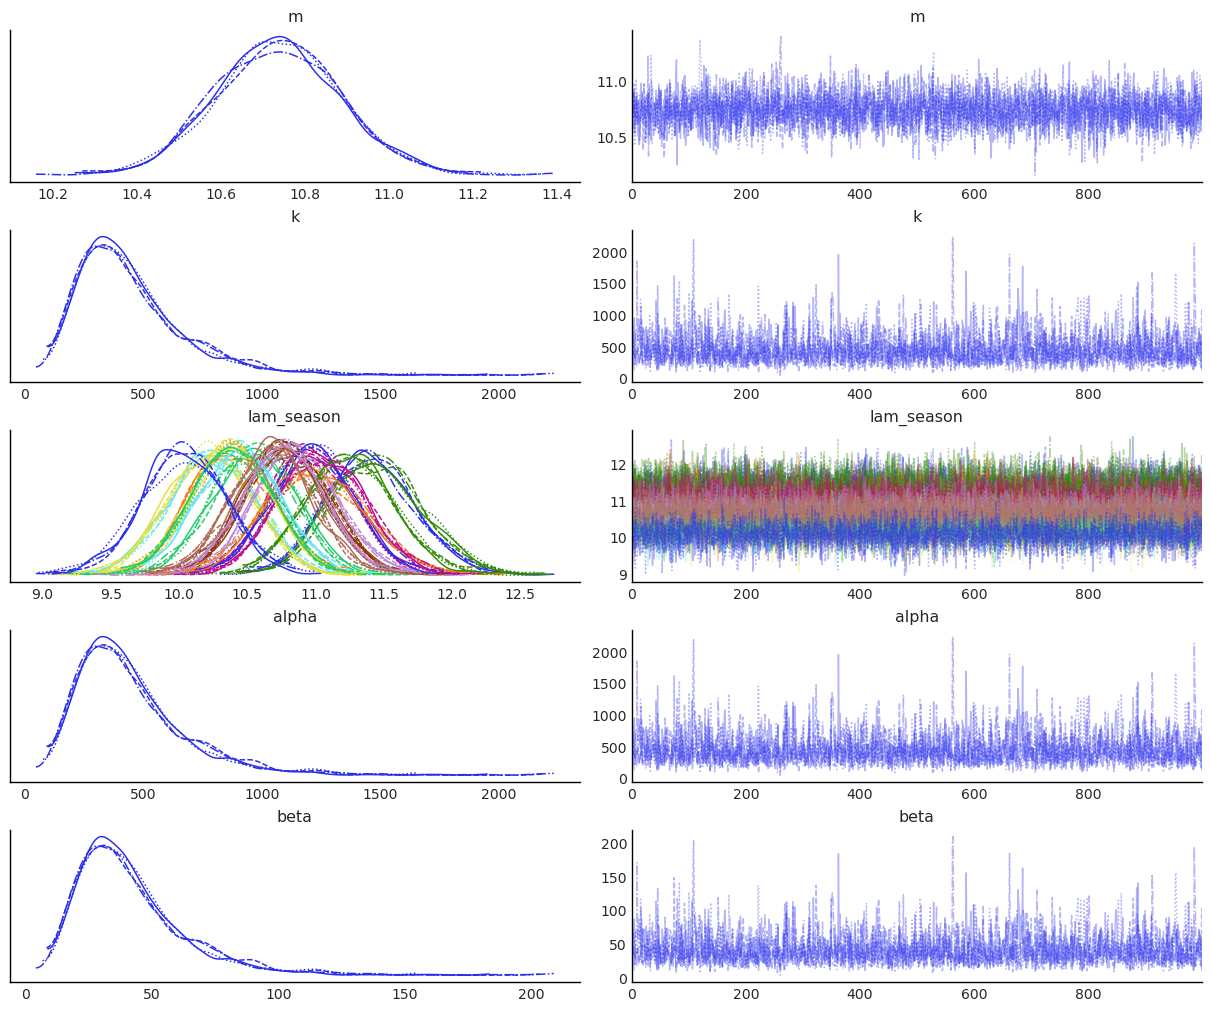

In [704]:
#| echo: false
#| output: false

# Trace plots to diagnose any sampling issues

az.plot_trace(trace)
plt.show()

After sampling, we get a (fairly lengthy) summary of the results containing estimated values for $m$ and $k$, each season's $\lambda$, and the $\alpha$ and $\beta$ values for the gamma distribution that governs the injury rate across seasons.

In [684]:
#| echo: false

pm.stats.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,10.737,0.149,10.468,11.049,0.002,0.002,4653.0,3193.0,1.0
k,447.801,239.400,105.454,916.098,5.244,6.931,2358.0,2682.0,1.0
lam_season[2000/01],11.402,0.328,10.770,12.060,0.004,0.006,5750.0,2856.0,1.0
lam_season[2001/02],10.386,0.302,9.834,11.012,0.004,0.005,7201.0,3419.0,1.0
lam_season[2002/03],11.453,0.340,10.813,12.132,0.004,0.006,6285.0,3081.0,1.0
lam_season[2003/04],10.969,0.302,10.363,11.538,0.003,0.005,7720.0,2936.0,1.0
lam_season[2005/06],10.803,0.305,10.219,11.385,0.003,0.006,8346.0,2811.0,1.0
lam_season[2006/07],10.244,0.314,9.631,10.851,0.004,0.005,8082.0,3474.0,1.0
lam_season[2007/08],10.226,0.312,9.664,10.861,0.004,0.005,6910.0,2921.0,1.0
lam_season[2008/09],10.548,0.305,9.952,11.138,0.003,0.005,8329.0,3307.0,1.0


The model appears to have sampled well (please see the full notebook for model diagnostics). Each season's mean $\lambda$ ranges from 10.09 to 11.37. The range is narrower than the table of simple averages above, as shrinkage pulls each season's rate toward the mean of the Gamma Distribution.

The expected injury rate for a given season is the mean of our simulated Gamma distribution, which is calculated as $\alpha \over \beta$. Using the $\alpha$ and $\beta$ values from our 4000 samples, the mean and 95% credible interval are:

In [717]:
alphas = trace.posterior['alpha'].values
betas = trace.posterior['beta'].values

gamma_means = (alphas / betas)
mean_lambda = gamma_means.mean().round(2)
gamma_quantiles = np.percentile(gamma_means, [2.5, 50, 97.5]).round(2)

print(f'Mean Lambda = {mean_lambda}')
print(f'95% credible interval: {gamma_quantiles[0]}, {gamma_quantiles[2]}')

Mean Lambda = 10.74
95% credible interval: 10.46, 11.04


So for any given season, we expect that the league-wide, per-game injury rate to be about 10.74 injuries. Accounting for uncertainty, we can be reasonably confident that the true latent value of $\lambda$ for a randomly selected season would fall between 10.46 and 11.04.

In [687]:
#| echo: false
#| output: false

with hier_injuries:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=['x'],
        random_seed=random_seed
    )

trace.extend(ppc)

Sampling: [x]


Output()

A posterior predictive check confirms that the model fits the data well. The blue region shows the an additional 4,000 simulated distributions generated by the parameters estimated in the model. The observed data (the black line) overlaps fully with the simulated data, and also aligns fairly well with the mean of the simulated distributions (the dashed orange line).

<Axes: xlabel='x'>

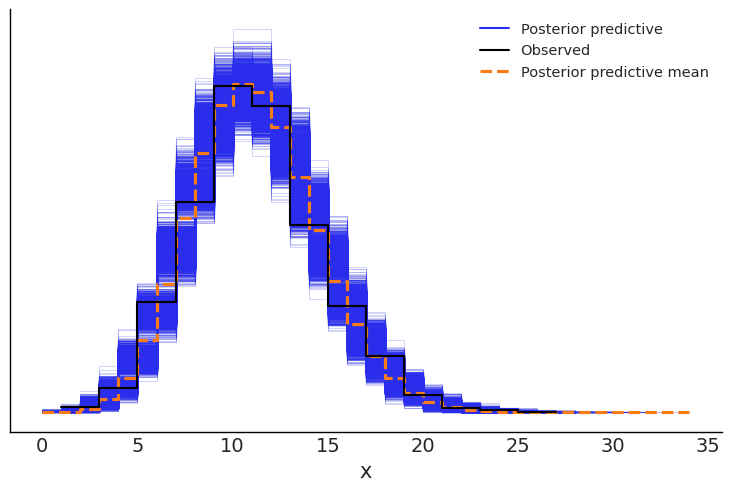

In [688]:
#| echo: false

az.plot_ppc(trace)

The next step is to repurpose the posterior gamma distribution from our hierarchical model as the prior distribution of $\lambda$ in a model to estimate in 2025/26 injury rate. In other words, before we even see the data from 2025, we'd expect the injury rate to be about 10.74 per game. This model combines that expectation with the likelihood of the data we've observed so far to estimate the underlying injury rate for the 2025/26 season. Importantly, this is not the injury rate through the first 29 games, but our best guess for the full-season rate, using everything we know about the past and the little bit we know about the present.

The model architecture is similar to the hierarchical model, but simpler because we have fewer variables to estimate. In fact, there's only one this time.

In [691]:
injuries_25 = injuries[(injuries['Season'] == '2025/26') & (injuries['Game'] <= 29)]
y_25 = injuries_25['Count'].to_numpy()
alpha_bar = alphas.mean()
beta_bar = betas.mean()

In [692]:
with pm.Model() as model_25:

    #prior
    lam = pm.Gamma('lam', alpha=alpha_bar, beta=beta_bar)

    #likelihood
    x = pm.Poisson('x', mu=lam, observed=y_25)

In [693]:
#| echo: false
#| output: false

with model_25:
    trace_25 = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


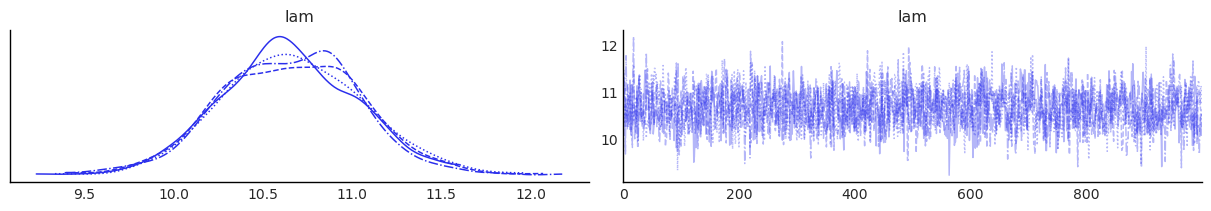

In [708]:
#| echo: false
#| output: false

az.plot_trace(trace_25)
plt.show()

In [ ]:
#| echo: false

pm.stats.summary(trace_25, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,10.653,0.388,9.921,11.441,0.01,0.006,1652.0,2624.0,1.0


Again, the model appears to have sampled well. The posterior estimate for 2025's injury rate is 10.65, which is actually *higher* than the simple average observed through game 29 (10.03). This means that the observed injury rate for 2025 so far is actually **lower than the model would expect**. 

Early in the season, the estimate for 2025 is pulled toward the historical center learned from past seasons, simply because there isn’t much 2025 data yet. As more games are played, the model will rely less on that historical baseline and more on what actually happens in 2025. The small amount of data also adds to the uncertainty of this estimate -  there's quite a wide credible interval for the estimate of the 2025 rate, ranging from 9.92 to 11.44. At the end of the year, the full season rate could plausibly fall anywhere within that range.

In [695]:
#| echo: false
#| output: false

with model_25:
    ppc_25 = pm.sample_posterior_predictive(
        trace,
        var_names=['x'],
        random_seed=random_seed
    )

trace_25.extend(ppc_25)

Sampling: [lam, x]


Output()

The uncertainty about 2025 also shows up in the posterior predictive plot, which is much "cloudier" than the plot from the first model. It's harder to make out here, but the observed data still falls within the simulations and close to the predictive mean, indicating a reasonably good fit (albeit with less certainty).

<Axes: xlabel='x'>

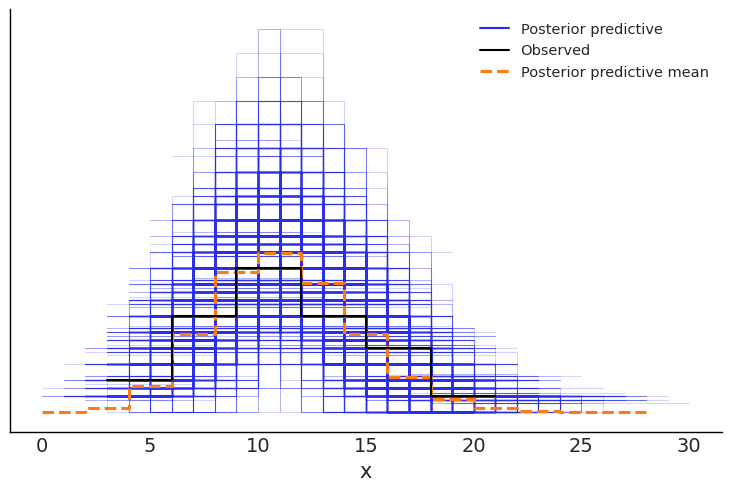

In [702]:
#| echo: false

az.plot_ppc(trace_25)

Having obtained a posterior estimate of 2025's injury rate, we can compare it with simulated data representing a typical NHL season to answer our original question: is the injury rate higher than normal this season? To do this, we'll use the $\alpha$ and $\beta$ values from the first model to simulate 4000 new injury rates for a "typical" NHL season.

To compare the typical season to the 2025 season, we compare all 4,000 values from each and count the percentage in which the 2025 rate is higher than the typical rate. The result is 45.48%, which is slightly worse than a coin flip.

In [718]:
hist_posterior = az.extract(trace)

alpha_draws = hist_posterior['alpha'].values.ravel()
beta_draws = hist_posterior['beta'].values.ravel()

rng = np.random.default_rng(random_seed)
lambda_samples = rng.gamma(shape=alpha_draws, scale= 1 / beta_draws)

posterior_25 = az.extract(trace_25)
lambda_samples_25 = posterior_25['lam'].values.ravel()

p_higher = (lambda_samples_25 > lambda_samples).mean() * 100

print(f'The probability the 2025/26 injury rate is higher by any amount: {p_higher:.2f}%') 

The probability the 2025/26 injury rate is higher by any amount: 45.48%


Knowing if 2025 is higher by any amount may not be that meaningful, though. How much higher would the injury rate need to be to categorize this season as abnormal? Arbitrarily, we could say the injury rate needs to be at least 0.5 injuries higher than the typical season.

In [699]:
lam_delta = 0.5

delta_prob = ((lambda_samples_25 - lambda_samples) > lam_delta).mean() * 100

print(f'The probability 2025/26 is at least 0.5 injuries per game higher: {delta_prob:.2f}%')

The probability 2025/26 is at least 0.5 injuries per game higher: 19.28%


Making that comparison yields a 19.28% probability that 2025's injury rate is significantly higher, which is obviously not great. Based on everything we've seen so far, I think we can say **the 2025/26 season isn't significantly different from past seasons.**

Lastly, we can use our estimated season-long injury rate to make some predictions (which will either age really well or quite poorly). First, using the lambda samples from the 2025 model, we can generate a point estimate for the total number of injuries we would observe through 29 games (excluding game 1). The model expects 298 injuries, which is a bit higher than what we've observed so far in 2025. This isn't too surprising - the partial pooling from the historic seasons is pulling our injury rate higher, resulting in a higher estimate.

In [700]:
total_through_29 = (lambda_samples_25 * 28).mean().round(2)

print(f'Expected Total Injuries Through 29 Games: {int(total_through_29)}')

Expected Total Injuries Through 29 Games: 298


Finally, we can apply the same technique to generate a prediction for the total number of injuries that will occur in the 2025/26 season. No one wants this number to be high, so this is one prediction I would be glad to miss. Since we're still several months away from the conclusion of the regular season, it also makes sense to add a credible interval, which is fairly wide.

In [711]:
pred_25 = lambda_samples_25 * 81
pred_interval = np.percentile(pred_25, [2.5, 97.5])

print(f'Expected 2025/26 Full-Season Injuries: {int(pred_25.mean())}')
print(f'95% Credible Interval for 2025/26 Injuries: {int(pred_interval[0])}, {int(pred_interval[1])}')

Expected 2025/26 Full-Season Injuries: 862
95% Credible Interval for 2025/26 Injuries: 801, 925


The model predicts 862 injuries by season's end, basically exactly in line with the 2023/24 season. The credible interval ranges from 808 (roughly in line with 2007/08), or as high as 925 (a little less than 2013/14). Here are the full-season counts for context:

In [709]:
#| echo: false

injuries[(injuries['Season'] != '2025/26') & ~injuries['Season'].isin(covid)][['Season','Count']].groupby('Season').sum()

,Count
Season,
2000/01,950
2001/02,828
2002/03,955
2003/04,898
2005/06,878
2006/07,811
2007/08,809
2008/09,847
2009/10,885


## Conclusion ##

Despite the media narratives about this season, the data show the injury rate is well within the historical range. So why does it *feel* like injuries are higher when they really aren't? I have a few theories:

1) We have short memories. The 2024/25 season featured a historically low number of injuries, perhaps due to the same randomness that's affected 2025 so far. Compared to last season, this year is much higher, but it's average when placed into a larger context.

2) Many of the injuries that occurred so far in 2025 were notable for various reasons. Some afflicted star players who play pivotal roles for their respective teams. Others involved bizarre circumstances, like the aforementioned [steak dinner](https://bleacherreport.com/articles/25294520-what-jack-hughes-injury-devils-star-reportedly-cut-hand-fluke-accident). When injuries involve star players or unusual events, they're more likely to stand out in our memory. The [availability heuristic](https://en.wikipedia.org/wiki/Availability_heuristic) is a cognitive bias, first documented by Daniel Kahneman and Amos Tversky, in which people overestimate the probability of an event if it's easily recalled. In other words, because these injuries are fresh in our minds, we overestimate their likelihood.

3) Once we're aware of a concept or idea, we're more likely to perceive it due to selective attention and [frequency bias](http://en.wikipedia.org/wiki/Frequency_illusion). I'll confess I may be guilty of this myself - once I became aware of the popular notion that injuries were occurring more frequently, I started noticing references to this "trend" much more frequently. If you're looking for something, you're more likely to find it.

It’s easy to see how these conclusions are drawn. When injuries cluster early in the season, our brains are wired to notice the pattern and extrapolate forward. Statistical modeling helps by forcing us to slow down, account for what we don't know, and ask whether what we’re seeing is actually unusual or just noisy. Even then, the answers aren’t definitive, but a little skepticism goes a long way.